In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from tqdm import trange
import numpy as np
from scipy.stats import multivariate_normal, triang
from zadania import BayesianDensityEstimator

In [14]:
class Distribution:
    def __init__(self, params):
        # params - wektor jednowymiarowy, w którym podajemy parametry rozkładu
        raise NotImplementedError()
    def pdf(self, x):
        # x - tablica o rozmiarze (liczba_xów, długość_wektora_danych)
        #
        # chcemy zwrócić wartości funkcji gęstości tego rozkładu w punktach
        # podanych w tablicy x, zwracamy tablicę o rozmiarze (liczba_xów,)
        raise NotImplementedError()
    def sample(self, n_samples, seed):
        # chcemy zwrócić n_samples sampli z tego rozkładu
        # losujemy z użyciem seed'a
        # zwracamy tablicę o rozmiarze (n_samples, długość_wektora_danych)
        raise NotImplementedError()

class Normal(Distribution):
    def __init__(self, mean):
        assert mean.shape == (2,)
        self.mean = mean
    def pdf(self, x):
        return multivariate_normal(self.mean).pdf(x)
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return rng.multivariate_normal(self.mean, [[1.,0.],[0.,1.]], size=n_samples)

class Uniform(Distribution):
    def __init__(self, mean):
        assert mean.shape == (2,)
        self.mean = mean
        self.scale = 3.
    def pdf(self, x):
        result = (np.max(np.abs(x - self.mean.reshape(1,2)), axis=1) <= .5 * self.scale)
        result = result.astype(np.float32).ravel() / (self.scale**2)
        return result
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return np.array([
            rng.uniform(self.mean[0] - .5 * self.scale, self.mean[0] + .5 * self.scale, size=n_samples),
            rng.uniform(self.mean[1] - .5 * self.scale, self.mean[1] + .5 * self.scale, size=n_samples)]).T

class Triangular(Distribution):
    def __init__(self, mean):
        assert mean.shape == (2,)
        self.mean = mean
    def pdf(self, x):
        return np.multiply(
            triang(c=.5, loc=self.mean[0]-1., scale=2.).pdf(x[:,0].ravel()),
            triang(c=.5, loc=self.mean[1]-1., scale=2.).pdf(x[:,1].ravel()))
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return np.array([
            rng.triangular(self.mean[0]-1., self.mean[0], self.mean[0]+1., size=n_samples),
            rng.triangular(self.mean[1]-1., self.mean[1], self.mean[1]+1., size=n_samples)]).T
    

In [3]:
# https://stackoverflow.com/questions/16657334/colormap-issue-using-animation-in-matplotlib

def draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs):

    x_from, x_to, n_x, y_from, y_to, n_y = grid_description

    extent = [x_from, x_to, y_to, y_from]

    true_pdf = true_pdf.reshape(n_y, n_x)
    posteriors = np.stack([arr.reshape(n_y, n_x) for arr in posteriors])
    ppds = np.stack([arr.reshape(n_y, n_x) for arr in ppds])
    likelihoods = np.stack([arr.reshape(n_y, n_x) for arr in likelihoods])

    fig = plt.figure(figsize=(8,8))

    ax1 = fig.add_subplot(2,2,1)
    ax1.set_title("Posterior")
    ax2 = fig.add_subplot(2,2,2)
    ax2.set_title("Posterior Predictive Distribution")
    ax3 = fig.add_subplot(2,2,3)
    ax3.set_title("Likelihood")
    ax4 = fig.add_subplot(2,2,4)
    ax4.set_title("True Distribution")

    def draw(i):

        if not draw.initialized:
        
            draw.im_posterior = ax1.imshow(
                posteriors[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            ax1.scatter(true_params[0], true_params[1], s=50, marker='x', c='red')

            draw.im_ppd = ax2.imshow(
                ppds[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            draw.s2 = ax2.scatter([], [], s=5)
            
            draw.im_likelihood = ax3.imshow(
                likelihoods[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            ax3.scatter(true_params[0], true_params[1], s=50, marker='x', c='red')
            
            draw.im_true_pdf = ax4.imshow(
                true_pdf,
                extent=extent,
                cmap="inferno")
            draw.s4 = ax4.scatter([], [], s=5)
            
            draw.initialized = True
        
        else:
        
            draw.im_posterior.set_data(posteriors[i])
            draw.im_posterior.autoscale()

            draw.im_ppd.set_data(ppds[i])
            draw.im_ppd.autoscale()
            draw.s2.set_offsets(obs[:i])

            draw.im_likelihood.set_data(likelihoods[i])
            draw.im_likelihood.autoscale()

            draw.s4.set_offsets(obs[:i])

    draw.initialized=False
    
    return animation.FuncAnimation(fig, draw, range(len(ppds)+1), blit=True, interval=500, repeat=True)

In [4]:
def learning_history(bayesian_density_estimator, params, gridpoints, observations):
    # w pętli:
    #   obserwujemy kolejny wylosowany punkt
    #   zapisujemy likelihood, posterior i ppd (potem będziemy ich używać przy rysowaniu animacji)
    posteriors = [bayesian_density_estimator.posterior]
    ppds = [bayesian_density_estimator.ppd(gridpoints)]
    # ustawiamy likelihood w zerowym kroku na jedynki
    # tak jest (chyba?) ładniej z matematycznego punktu widzenia
    likelihoods = [np.ones(len(params), dtype=np.float)]
    for i in trange(len(obs)):
        bayesian_density_estimator.observe(obs[i:i+1,:])
        posteriors.append(bayesian_density_estimator.posterior.copy())
        ppds.append(bayesian_density_estimator.ppd(gridpoints).copy())
        likelihoods.append(bayesian_density_estimator.likelihood(obs[:i+1,:]))
    return posteriors, ppds, likelihoods

In [5]:
# W całym notebooku używamy dwuwymiarowej siatki parametrów
# na kwadracie [-3,3] x [-3,3]
# punkty rozmieszczone są co 0.2
#
# W razie potrzeby można ją zwiększyć/zmniejszyć/zagęścić/rozrzedzić

x_from, x_to, n_x = -3., 3., 31
y_from, y_to, n_y = -3., 3., 31
grid_description = [x_from, x_to, n_x, y_from, y_to, n_y]

x = np.linspace(x_from, x_to, n_x)
y = np.linspace(y_from, y_to, n_y)

params = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
gridpoints = params # dla wygody, ale pamiętamy, że to dwie różne rzeczy!

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


<IPython.core.display.Javascript object>


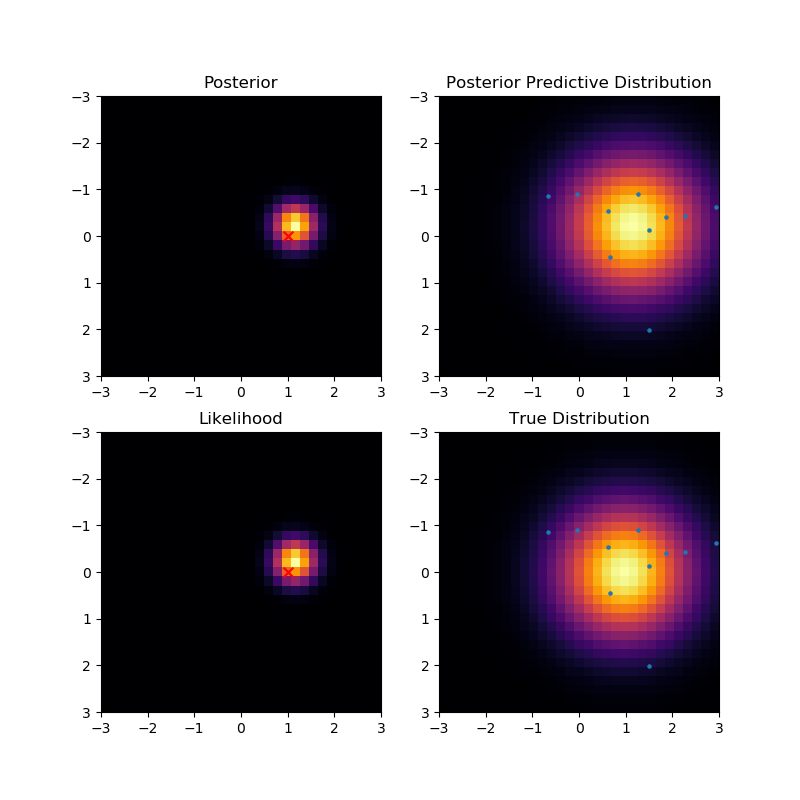

In [6]:
# PRZYKŁAD 1: ROZKŁAD NORMALNY

# ustawiamy prawdziwy rozkład na rozkład normalny o średniej (1.,0.)
true_params = np.array([1.,0.])
true_distr = Normal(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(gridpoints)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(10)
# wybieramy prior na parametrach rozkładów
uniform_prior = np.full(shape=len(params), fill_value=1./len(params))
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Normal,
    params=params,
    prior=uniform_prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


<IPython.core.display.Javascript object>


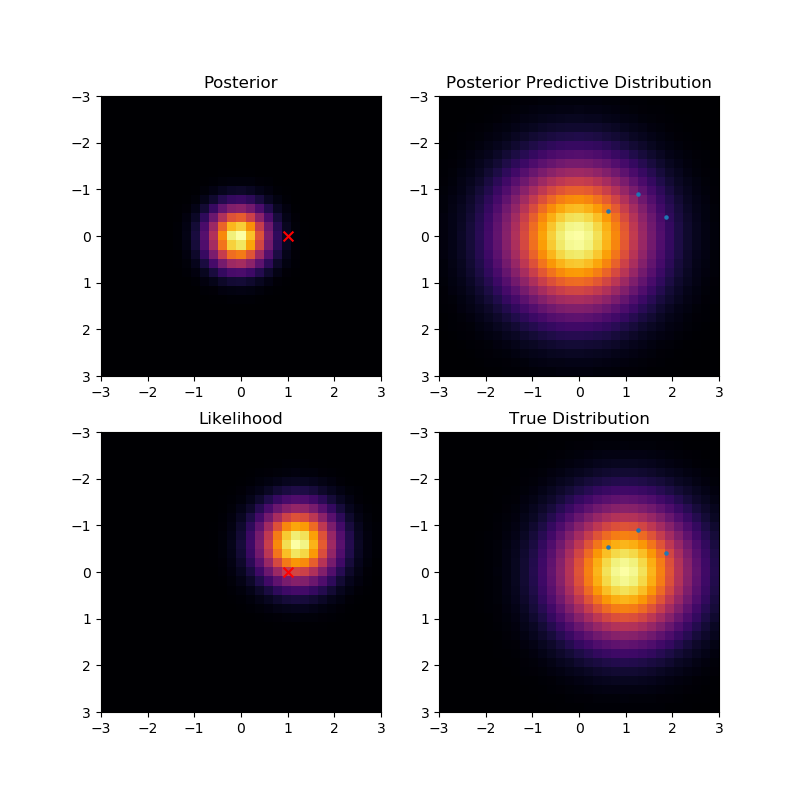

In [7]:
# PRZYKŁAD 2: ROZKŁAD NORMALNY Z NIEJEDNOSTAJNYM PRIOREM

# ustawiamy prawdziwy rozkład na rozkład normalny o średniej (1.,0.)
true_params = np.array([1.,0.])
true_distr = Normal(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(gridpoints)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(10)
# wybieramy prior na parametrach rozkładów
prior = np.exp(-np.sum(np.square(params + np.array([[2.,-1.]])), axis=1))
prior /= prior.sum()
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Normal,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)

100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


<IPython.core.display.Javascript object>


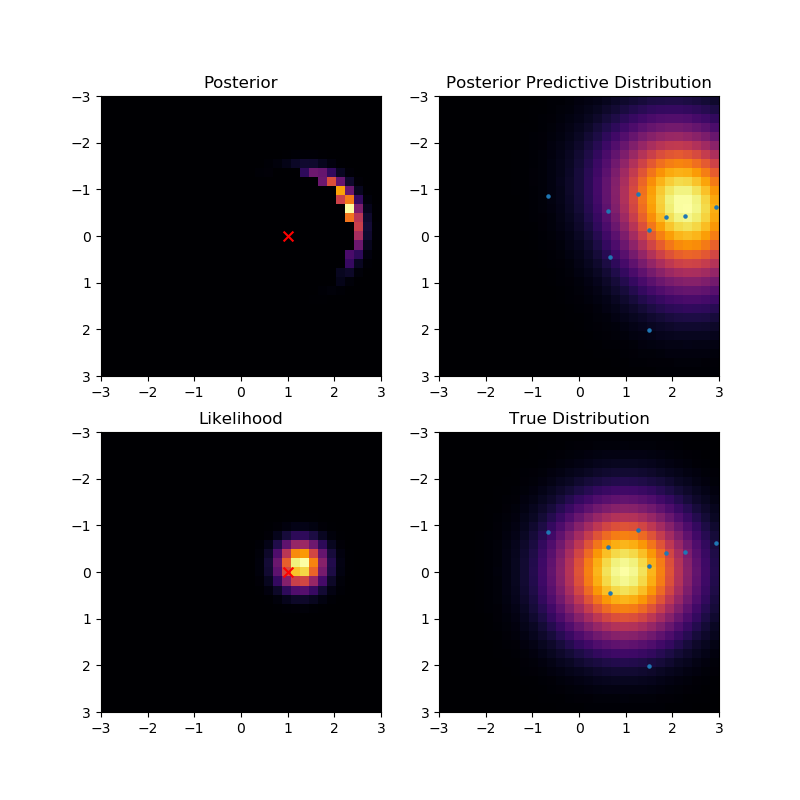

In [8]:
# PRZYKŁAD 3: ZEROWY PRIOR W OTOCZENIU L2 PRAWDZIWEGO PARAMETRU

# ustawiamy prawdziwy rozkład na rozkład normalny o średniej (1.,0.)
true_params = np.array([1.,0.])
true_distr = Normal(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(params).reshape(n_y, n_x)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(30)
# wybieramy prior na parametrach rozkładów
prior = np.maximum(0., np.sum(np.square(params - true_params), axis=1) - 2.)
prior /= prior.sum()
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Normal,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)

100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


<IPython.core.display.Javascript object>


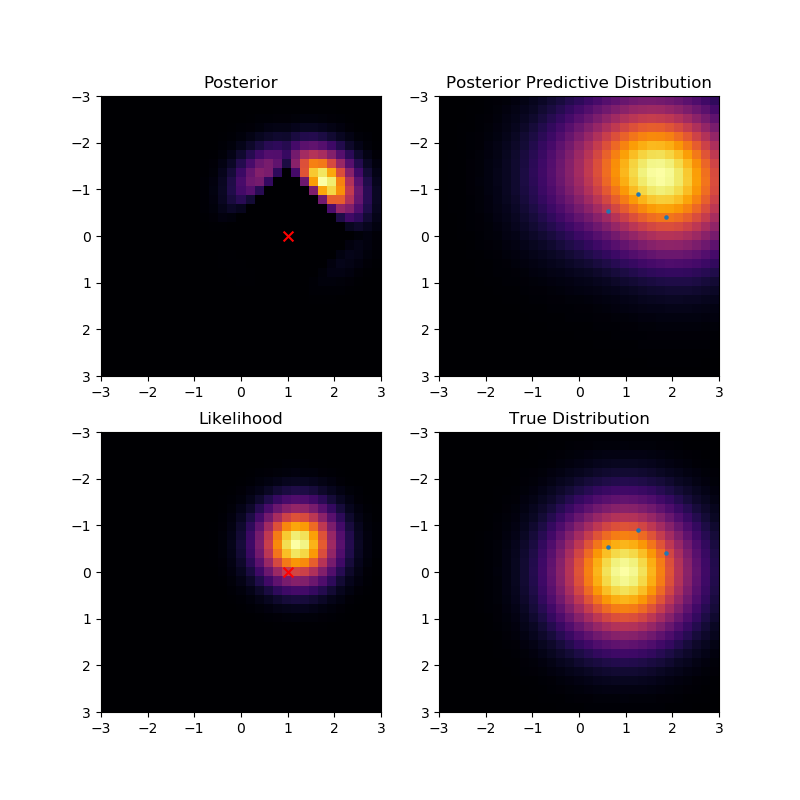

In [9]:
# PRZYKŁAD 4: ZEROWY PRIOR W OTOCZENIU L1 PRAWDZIWEGO PARAMETRU

# ustawiamy prawdziwy rozkład na rozkład normalny o średniej (1.,0.)
true_params = np.array([1.,0.])
true_distr = Normal(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(params).reshape(n_y, n_x)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(30)
# wybieramy prior na parametrach rozkładów
prior = np.maximum(0., np.sum(np.abs(params - true_params), axis=1) - 1.5)
prior /= prior.sum()
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Normal,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)

100%|██████████| 30/30 [00:02<00:00, 10.00it/s]


<IPython.core.display.Javascript object>


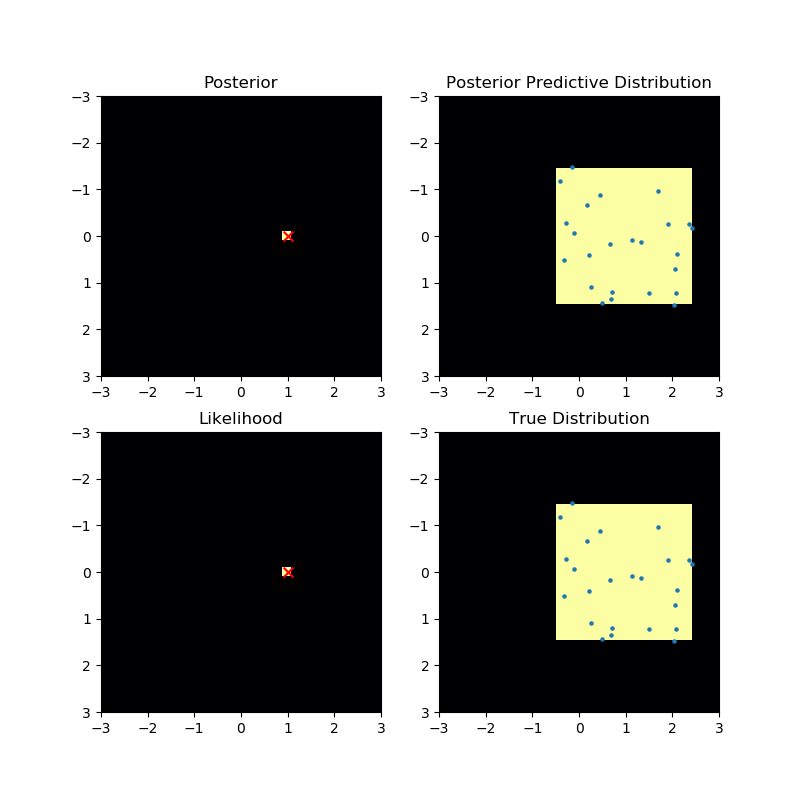

In [10]:
# PRZYKŁAD 5: ROZKŁAD JEDNOSTAJNY

# ustawiamy prawdziwy rozkład na rozkład jednostajny na kwadracie o środku (1.,0.)
true_params = np.array([1.,0.])
true_distr = Uniform(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(params).reshape(n_y, n_x)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(30)
# wybieramy prior na parametrach rozkładów
prior = np.exp(-np.sum(np.square(params), axis=1))
prior /= prior.sum()
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Uniform,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)

100%|██████████| 30/30 [00:03<00:00,  9.79it/s]


<IPython.core.display.Javascript object>


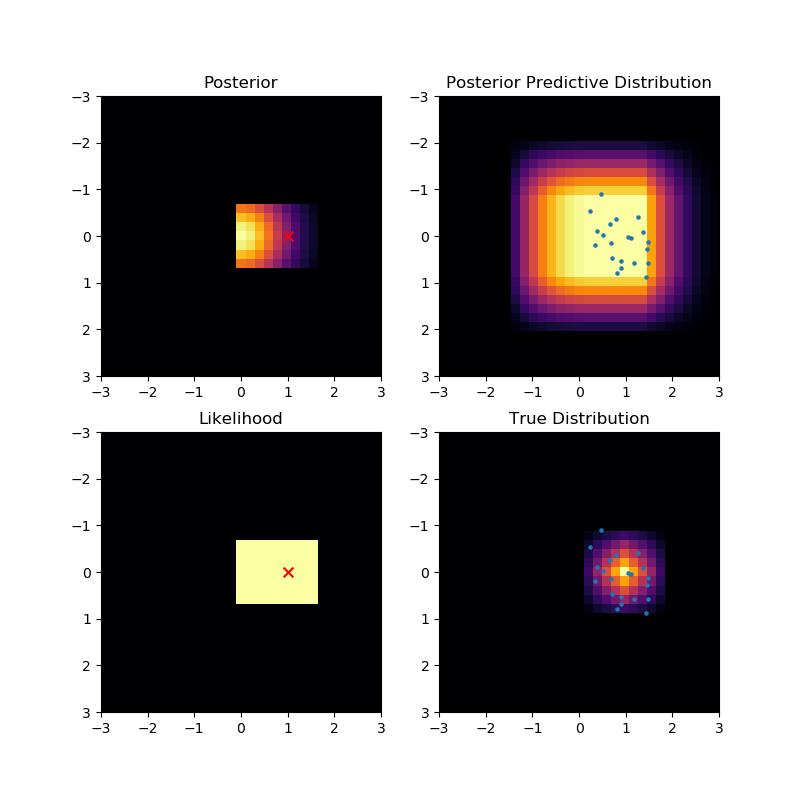

In [11]:
# PRZYKŁAD 6: CO SIĘ STANIE, JEŚLI MAMY ZŁY MODEL?
# ESTYMACJA ROZKŁADU TRÓJKĄTNEGO ROZKŁADAMI JEDNOSTAJNYMI

# ustawiamy prawdziwy rozkład na rozkład jednostajny na kwadracie o środku (1.,0.)
true_params = np.array([1.,0.])
true_distr = Triangular(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(params).reshape(n_y, n_x)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(30)
# wybieramy prior na parametrach rozkładów
prior = np.exp(-np.sum(np.square(params), axis=1))
prior /= prior.sum()
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Uniform,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


<IPython.core.display.Javascript object>


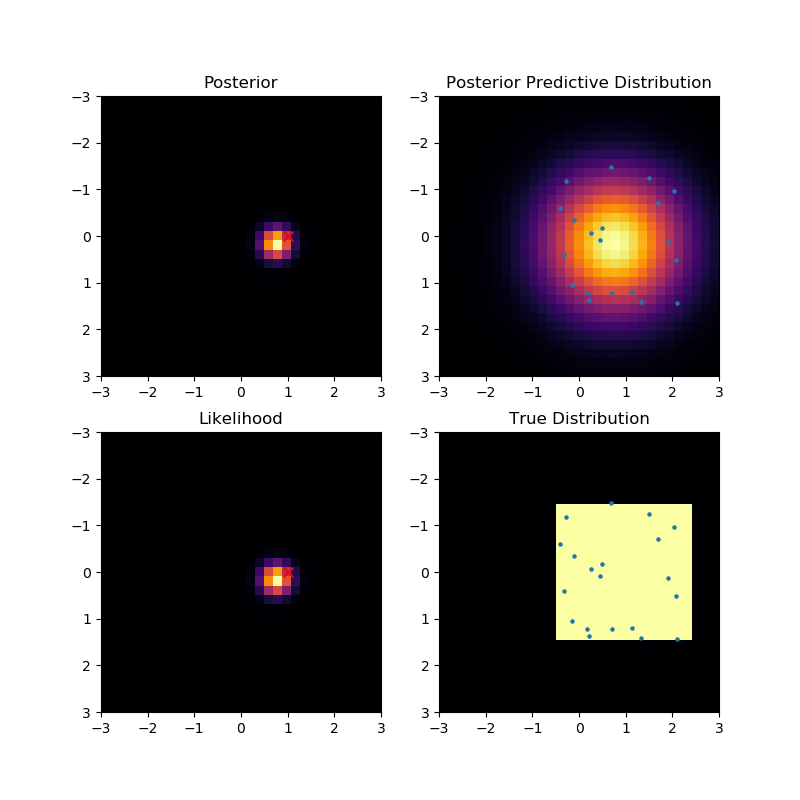

In [12]:
# PRZYKŁAD 7: CO SIĘ STANIE, JEŚLI MAMY ZŁY MODEL?
# ESTYMACJA ROZKŁADU JEDNOSTAJNEGO ROZKŁADAMI NORMALNYMI

# ustawiamy prawdziwy rozkład na rozkład jednostajny na kwadracie o środku (1.,0.)
true_params = np.array([1.,0.])
true_distr = Uniform(true_params)
# wypisujemy gęstość prawdziwego rozkładu na siatce
true_pdf = true_distr.pdf(params).reshape(n_y, n_x)
# generujemy obserwacje z prawdziwego rozkładu
obs = true_distr.sample(20)
# wybieramy prior na parametrach rozkładów
prior = np.full(len(params), 1./len(params))
# tworzymy instancję estymatora
bde = BayesianDensityEstimator(
    distr_cls=Normal,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_density_estimator=bde,
    params=params,
    gridpoints=gridpoints,
    observations=obs)
# uruchamiamy animację
draw_animation(grid_description, true_params, true_distr, posteriors, ppds, likelihoods, true_pdf, obs)